In [1]:
import mlflow
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import datetime

In [2]:
# we want to keep track of our experiments - Every project is an experiment
# within the experiment we can have multiple runs/ models
# set the name of our experiment
mlflow.set_experiment("loan_default_pred")

2026/01/24 19:23:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/01/24 19:23:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/01/24 19:23:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/01/24 19:23:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/01/24 19:23:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/01/24 19:23:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/01/24 19:23:44 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/24 19:23:44 INFO mlflow.store.db.utils: Updating database tables
2026/01/24 19:23:44 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/24 19:23:44 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/24 19:23:47 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/24 19:23:47 INFO alembic.runtime

<Experiment: artifact_location='file:c:/Users/itviv/Documents/GitHub/learning_streamlit/mlruns/1', creation_time=1769251704081, experiment_id='1', last_update_time=1769251704081, lifecycle_stage='active', name='loan_default_pred', tags={}>

In [3]:
mlflow.enable_system_metrics_logging()

In [4]:
data = pd.read_csv("LoanTap_Data_Streamlit.csv")

C:\Users\itviv\AppData\Local\Temp\ipykernel_4772\2723465646.py:1: DtypeWarning: Columns (2,4,5,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("LoanTap_Data_Streamlit.csv")


In [5]:
data = data.dropna()

loan_label= {'Fully Paid':0, 'Charged Off':1}
data['loan_status'] = data['loan_status'].replace(loan_label)
data['zip_code'] = data['address'].astype(str).str[-5:]

X = data[data.columns.drop(['loan_status','address'])]
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_cols = ['grade','zip_code','application_type','purpose']

te = TargetEncoder(cols=cat_cols)
X_train[cat_cols] = te.fit_transform(X_train[cat_cols], y_train)
X_test[cat_cols] = te.transform(X_test[cat_cols])

C:\Users\itviv\AppData\Local\Temp\ipykernel_4772\1780818132.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['loan_status'] = data['loan_status'].replace(loan_label)


2026/01/24 19:30:25 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2026/01/24 19:30:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2026/01/24 19:32:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/24 19:33:39 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2026/01/24 19:33:39 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


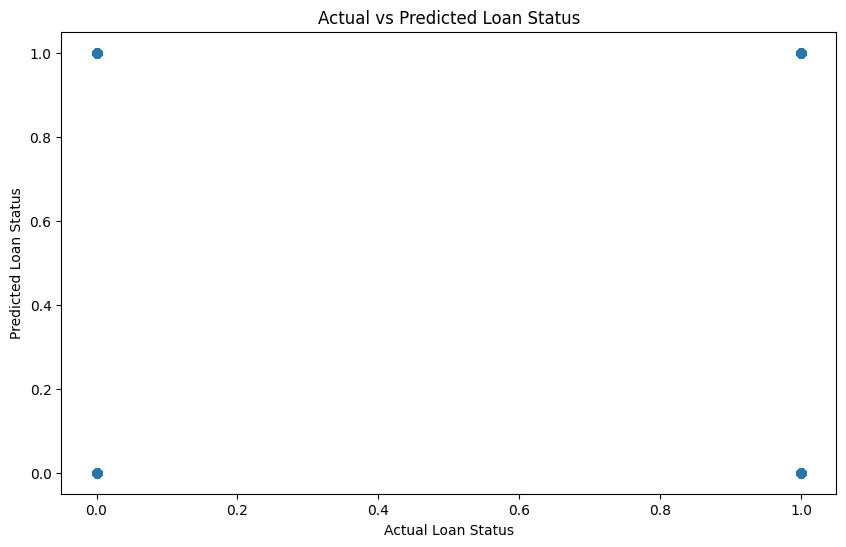

In [7]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

mlflow.enable_system_metrics_logging()

# Anything that u want to track will come under the below piece of code "mlflow.start_run"
# Experiment starts running from here
with mlflow.start_run(run_name= f"loan_pred_model_{now}") as run:

    n_estimators = 1000
    learning_rate = 0.06
    max_depth = 20
    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth
    )

    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Storing the hyperparameters
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("n_estimators", n_estimators)
    # Storing the model metrics
    mlflow.log_metric("mape", mape)

    # Storing the dataset features
    mlflow.log_metric("No of rows", data.shape[0])
    mlflow.log_metric("No of features", data.shape[1])
    mlflow.log_metric("No of features", len(X.columns))
    # Storing images as artifacts
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel("Actual Loan Status")
    plt.ylabel("Predicted Loan Status")
    plt.title("Actual vs Predicted Loan Status")
    plt.savefig("actual_vs_predicted.png")
    mlflow.log_artifact("actual_vs_predicted.png")
    # Storing the model itself
    mlflow.sklearn.log_model(xgb_model, artifact_path="xgboost-model")

In [ ]:
import subprocess

port = 5000
log = open("mlflow_ui.log", "wb")
mlflow_process = subprocess.Popen(["mlflow", "ui", "--port", str(port)], stdout=log, stderr=log)
print(f"Started mlflow ui at http://127.0.0.1:{port} (pid {mlflow_process.pid}), logs -> mlflow_ui.log")